
[Hold-out ARIMA] Total guest nights | order=(1, 1, 1) | AIC=111.954

[Hold-out ARIMA] International guest nights | order=(1, 1, 1) | AIC=-1.993

[Hold-out ARIMA] Domestic guest nights | order=(1, 1, 1) | AIC=138.015

[Hold-out] 2024-07-31 → 2025-06-30

Total guest nights
  RMSE : 5,908,192.329
  MAE  : 4,828,228.442
  MAPE : 32.795%
  sMAPE: 41.630%

International guest nights
  RMSE : 3,118,211.809
  MAE  : 2,645,632.157
  MAPE : 52.298%
  sMAPE: 74.797%

Domestic guest nights
  RMSE : 3,110,473.182
  MAE  : 2,479,941.268
  MAPE : 26.048%
  sMAPE: 31.572%

[Full-fit ARIMA] Total guest nights | order=(1, 1, 1) | AIC=134.148

[Full-fit ARIMA] International guest nights | order=(1, 1, 1) | AIC=-8.416

[Full-fit ARIMA] Domestic guest nights | order=(1, 1, 1) | AIC=170.326

[ARIMA] Combined forecast window

Forecast results saved to: ../output/Model_02_ARIMA_ADP.csv


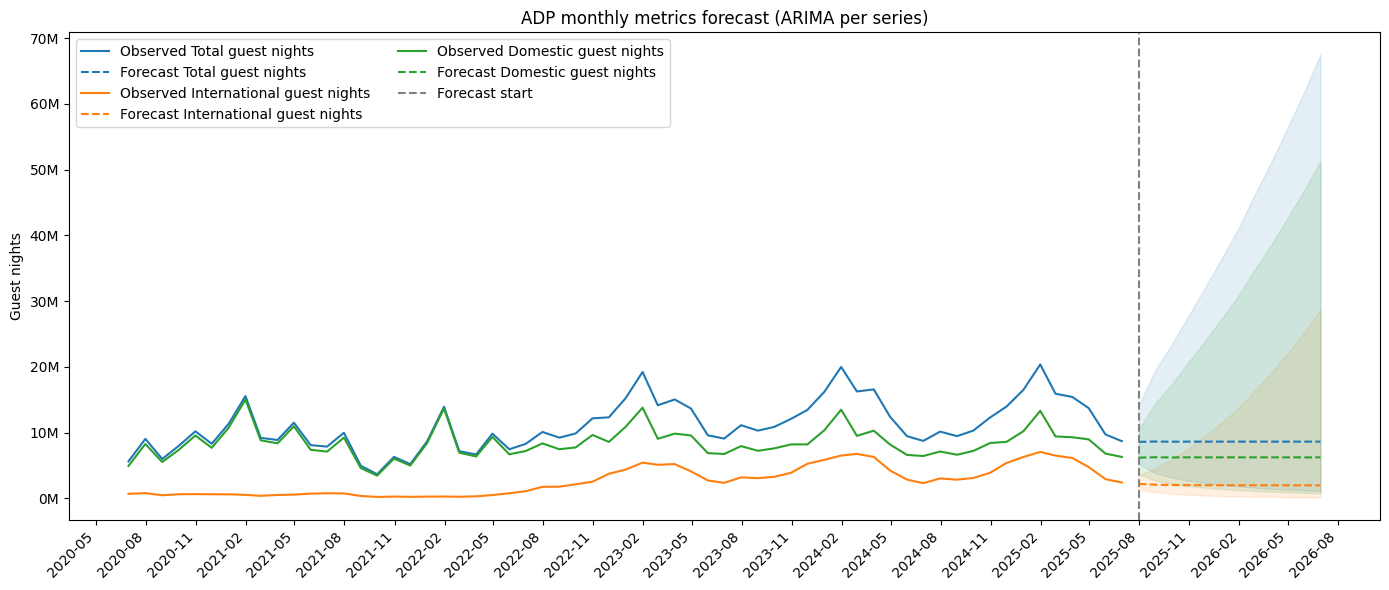

In [2]:
# model_03_arima_adp.py
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.arima.model import ARIMA

# ----------------------- Config -----------------------
ADP_CSV = "../datasets/ADP_All_Measures.csv"

HORIZON = 12
HOLDOUT_STEPS = 12

SERIES = [
    "Total guest nights",
    "International guest nights",
    "Domestic guest nights",
]

# Default ARIMA orders per series (tweak if needed)
ARIMA_ORDERS = {
    "Total guest nights": (1, 1, 1),
    "International guest nights": (1, 1, 1),
    "Domestic guest nights": (1, 1, 1),
}

# ----------------------- Helpers -----------------------
def full_month_range(idx):
    start = pd.to_datetime(idx.min()) + MonthEnd(0)
    end = pd.to_datetime(idx.max()) + MonthEnd(0)
    return pd.date_range(start=start, end=end, freq="ME")

def configure_ax(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

def print_banner(s):
    bar = "=" * len(s)
    print(f"\n{bar}\n{s}\n{bar}")

# ----------------------- Load & Aggregate ADP -----------------------
def load_adp_national(adp_csv: str) -> pd.DataFrame:
    adp = pd.read_csv(adp_csv)
    adp["Month"] = pd.to_datetime(adp["Month"], format="%Y-%m-%d", errors="coerce")
    adp["Date"] = adp["Month"] + MonthEnd(0)

    if "Total guest nights" not in adp.columns:
        if {"Domestic guest nights", "International guest nights"}.issubset(adp.columns):
            adp["Total guest nights"] = (
                adp["Domestic guest nights"] + adp["International guest nights"]
            )
        else:
            raise ValueError("Missing both 'Total guest nights' and components to construct it.")

    g = adp.groupby("Date")[SERIES].sum(min_count=1).sort_index()
    idx = full_month_range(g.index)
    g = g.reindex(idx).ffill().bfill()
    return g

# ----------------------- Transformations -----------------------
def forward_transform(df: pd.DataFrame):
    """
    Log1p + standardize (mean/sd) so ARIMA works on roughly stationary scale.
    We’ll forecast on z_std and invert via expm1 after destandardizing.
    """
    z = np.log1p(df.clip(lower=0))
    mu, sd = z.mean(), z.std(ddof=0).replace(0, 1.0)
    z_std = (z - mu) / sd
    return z_std, {"mu": mu, "sd": sd}

def inverse_transform(z_std: pd.DataFrame, meta: dict):
    z = z_std * meta["sd"] + meta["mu"]
    return np.expm1(z).clip(lower=0)

# ----------------------- Metrics -----------------------
def _rmse(a, f):
    return float(np.sqrt(np.mean((np.asarray(a, float) - np.asarray(f, float)) ** 2)))

def _mae(a, f):
    return float(np.mean(np.abs(np.asarray(a, float) - np.asarray(f, float))))

def _mape(a, f):
    a, f = np.asarray(a, float), np.asarray(f, float)
    mask = a != 0
    return float(np.mean(np.abs((a[mask] - f[mask]) / a[mask])) * 100) if mask.any() else np.nan

def _smape(a, f):
    a, f = np.asarray(a, float), np.asarray(f, float)
    denom = np.abs(a) + np.abs(f)
    mask = denom != 0
    return float(np.mean(2 * np.abs(a[mask] - f[mask]) / denom[mask]) * 100) if mask.any() else np.nan

def print_metrics_block(title, actual: pd.Series, forecast: pd.Series):
    print_banner(title)
    print(f"  RMSE : {_rmse(actual, forecast):,.3f}")
    print(f"  MAE  : {_mae(actual, forecast):,.3f}")
    print(f"  MAPE : {_mape(actual, forecast):.3f}%")
    print(f"  sMAPE: {_smape(actual, forecast):.3f}%")

# ----------------------- Per-series ARIMA fit/forecast -----------------------
def _fit_arima_1d(y: pd.Series, order):
    """
    Fit ARIMA on a single transformed series (z_std).
    Robust fallback: if the chosen order fails, try a small set of safe fallbacks.
    """
    try_orders = [order, (1,1,0), (0,1,1), (0,1,0)]
    last_err = None
    for ord_ in try_orders:
        try:
            mod = ARIMA(endog=y, order=ord_, enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit()
            return res, ord_
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"ARIMA failed for all tried orders. Last error: {last_err}")

def _forecast_with_ci(res, steps, start_next_dtindex):
    """
    Get forecast mean and CI (on transformed scale) and align to a given monthly index.
    """
    fc = res.get_forecast(steps=steps)
    mu = fc.predicted_mean.copy()
    ci = fc.conf_int().copy()
    idx = pd.date_range(start=start_next_dtindex, periods=steps, freq="ME")
    mu.index = idx
    ci.index = idx
    return mu, ci

# ----------------------- Hold-out evaluation -----------------------
def evaluate_holdout_arima(g: pd.DataFrame, holdout_steps: int = HOLDOUT_STEPS, arima_orders: dict = None):
    if len(g) < (holdout_steps + 36):
        holdout_steps = max(6, len(g) - 36)
    if holdout_steps <= 0:
        return

    orders = arima_orders or ARIMA_ORDERS
    train_g, test_g = g.iloc[:-holdout_steps], g.iloc[-holdout_steps:]
    z_train, meta_train = forward_transform(train_g)

    # Prepare containers for transformed forecasts
    mu_test_std = pd.DataFrame(index=test_g.index, columns=SERIES, dtype="float64")
    # Also keep CIs per series (transformed scale)
    ci_lower_std = pd.DataFrame(index=test_g.index, columns=SERIES, dtype="float64")
    ci_upper_std = pd.DataFrame(index=test_g.index, columns=SERIES, dtype="float64")

    # Fit & forecast each series independently on transformed scale
    start_next = train_g.index[-1] + MonthEnd(1)

    for col in SERIES:
        res, used_order = _fit_arima_1d(z_train[col].dropna(), orders.get(col, (1,1,1)))
        mu_col, ci_col = _forecast_with_ci(res, holdout_steps, start_next)

        mu_test_std[col] = mu_col
        ci_lower_std[col] = ci_col.iloc[:, 0]
        ci_upper_std[col] = ci_col.iloc[:, 1]

        print_banner(f"[Hold-out ARIMA] {col} | order={used_order} | AIC={res.aic:.3f}")

    # Inverse transform means and CIs to level space
    fc_test_levels = inverse_transform(mu_test_std, meta_train)
    fc_lo_levels  = inverse_transform(ci_lower_std, meta_train)
    fc_hi_levels  = inverse_transform(ci_upper_std, meta_train)

    # Metrics
    print_banner(f"[Hold-out] {test_g.index[0].date()} → {test_g.index[-1].date()}")
    for col in SERIES:
        print_metrics_block(col, test_g[col], fc_test_levels[col])

# ----------------------- Full-fit & future forecast -----------------------
def fit_full_and_forecast_arima(g: pd.DataFrame, horizon: int = HORIZON, arima_orders: dict = None):
    orders = arima_orders or ARIMA_ORDERS
    z_full, meta_full = forward_transform(g)

    mu_future_std = pd.DataFrame(
        index=pd.date_range(g.index[-1] + MonthEnd(1), periods=horizon, freq="ME"),
        columns=SERIES,
        dtype="float64",
    )
    ci_lower_std = mu_future_std.copy()
    ci_upper_std = mu_future_std.copy()

    for col in SERIES:
        res, used_order = _fit_arima_1d(z_full[col].dropna(), orders.get(col, (1,1,1)))
        start_next = g.index[-1] + MonthEnd(1)
        mu_col, ci_col = _forecast_with_ci(res, horizon, start_next)

        mu_future_std[col] = mu_col
        ci_lower_std[col] = ci_col.iloc[:, 0]
        ci_upper_std[col] = ci_col.iloc[:, 1]

        print_banner(f"[Full-fit ARIMA] {col} | order={used_order} | AIC={res.aic:.3f}")

    # Back-transform to levels
    fc_levels = inverse_transform(mu_future_std, meta_full)
    fc_lo     = inverse_transform(ci_lower_std, meta_full)
    fc_hi     = inverse_transform(ci_upper_std, meta_full)

    return fc_levels, fc_lo, fc_hi

# ----------------------- Main -----------------------
def main():
    g = load_adp_national(ADP_CSV)

    # Holdout performance (OOS metrics)
    evaluate_holdout_arima(g, holdout_steps=HOLDOUT_STEPS, arima_orders=ARIMA_ORDERS)

    # Fit on full data and forecast horizon
    fc_levels, fc_lo, fc_hi = fit_full_and_forecast_arima(g, HORIZON, ARIMA_ORDERS)

    start_fc = fc_levels.index[0]
    observed = g.copy()

    print_banner("[ARIMA] Combined forecast window")

    # ---------------- Save forecast results ----------------
    # One wide CSV: Forecast/Lower/Upper for each series
    out = pd.DataFrame(index=fc_levels.index)
    for col in SERIES:
        out[f"Forecast {col}"] = fc_levels[col]
        out[f"Lower_CI {col}"] = fc_lo[col]
        out[f"Upper_CI {col}"] = fc_hi[col]

    out.index.name = "Date"
    out_csv = "../output/Model_02_ARIMA_ADP.csv"
    out.to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    # ---------------- Combined plot ----------------
    plt.figure(figsize=(14, 6))
    colors = {
        "Total guest nights": "#1f77b4",
        "International guest nights": "#ff7f0e",
        "Domestic guest nights": "#2ca02c",
    }
    for col in SERIES:
        # Observed
        plt.plot(observed.index, observed[col], label=f"Observed {col}", color=colors[col])
        # Forecast
        plt.plot(fc_levels.index, fc_levels[col], linestyle="--", label=f"Forecast {col}", color=colors[col])
        # Simple CI band per series (can overlap visually)
        plt.fill_between(fc_levels.index, fc_lo[col], fc_hi[col], color=colors[col], alpha=0.12)

    plt.axvline(start_fc, color="gray", linestyle="--", label="Forecast start")
    plt.title("ADP monthly metrics forecast (ARIMA per series)")
    plt.ylabel("Guest nights")
    plt.legend(loc="upper left", ncol=2, frameon=True)
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x*1e-6:,.0f}M"))
    configure_ax(plt.gca())
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
